In [23]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

!pip install apafib
from time import time
import datetime

# Ejercicio 3: Blowing in the wind


El conjunto de datos Wind Speed Prediction Dataset tiene mediciones de diferentes va-
riables tomadas por una estación meteorológica durante 15 años. El objetivo es predecir el valor
de la variable WIND usando ventanas de datos pasados.
Trabajaremos con una versión de este conjunto que podéis obtener mediante la función
load_wind_prediction de la librería apafib. Resuelve los siguientes apartados ilustrando
los resultados de la manera que te parezca más adecuada.

Realizaremos todos los imports que necesitaremos durante el ejercicio:

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, QuantileRegressor, Ridge, Lasso # modelos utilizados
from sklearn.metrics import mean_absolute_error # lo usaremos para medir la calidad del modelo
from sklearn import set_config

from yellowbrick.regressor import residuals_plot # q-q plots y residuos

import statsmodels.api as sm
from scipy import stats

import warnings

set_config(display='text')
warnings.filterwarnings('ignore')

sns.set()
pd.set_option('display.precision', 3)

En primer lugar haremos una lectura de los datos:

In [25]:
# Cargamos los datos
from apafib import load_wind_prediction
lwp_data = load_wind_prediction()

# Eliminamos espacios y símbolos
lwp_data.columns = [c.lower().strip().replace(' ','_').replace('/','_').replace('-','_') 
                                for c in lwp_data.columns] 

# Cambiamos a variables categóricas de pandas
categorical_columns = list(lwp_data.dtypes[lwp_data.dtypes == 'O'].index.values)
for column in categorical_columns:
    lwp_data[column] = lwp_data[column].astype('category')

lwp_data.head()

,date,wind,ind,rain,ind.1,t.max,ind.2,t.min,t.min.g
0,1961-01-01,13.67,0,0.2,0.0,9.5,0.0,3.7,-1.0
1,1961-01-02,11.50,0,5.1,0.0,7.2,0.0,4.2,1.1
2,1961-01-03,11.25,0,0.4,0.0,5.5,0.0,0.5,-0.5
3,1961-01-04,8.63,0,0.2,0.0,5.6,0.0,0.4,-3.2
4,1961-01-05,11.92,0,10.4,0.0,7.2,1.0,-1.5,-7.5


Reordenamos para que WIND, nuestra variable respuesta, sea la primera columna


In [26]:
cols = list(lwp_data.columns)
cols.remove('wind')
cols.insert(0, 'wind')
lwp_data = lwp_data.reindex(columns=cols)
lwp_data.describe(include='all').T
lwp_data.info()


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
wind,6574.0,NaN,NaN,NaN,9.797,4.977,0.0,6.0,9.21,12.96,30.37
date,6574,6574,1961-01-01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ind,6574.0,NaN,NaN,NaN,0.392,1.179,0.0,0.0,0.0,0.0,4.0
rain,6574.0,NaN,NaN,NaN,1.885,4.031,0.0,0.0,0.2,2.0,67.0
ind.1,6513.0,NaN,NaN,NaN,0.356,1.129,0.0,0.0,0.0,0.0,4.0
t.max,5953.0,NaN,NaN,NaN,13.339,4.891,-0.1,9.6,13.3,17.2,26.8
ind.2,6513.0,NaN,NaN,NaN,0.464,1.178,0.0,0.0,0.0,0.0,4.0
t.min,5900.0,NaN,NaN,NaN,6.412,4.637,-11.5,3.0,6.5,10.0,18.0
t.min.g,6214.0,NaN,NaN,NaN,2.737,5.569,-14.4,-1.0,3.0,7.0,15.8


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6574 entries, 0 to 6573
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   wind     6574 non-null   float64 
 1   date     6574 non-null   category
 2   ind      6574 non-null   int64   
 3   rain     6574 non-null   float64 
 4   ind.1    6513 non-null   float64 
 5   t.max    5953 non-null   float64 
 6   ind.2    6513 non-null   float64 
 7   t.min    5900 non-null   float64 
 8   t.min.g  6214 non-null   float64 
dtypes: category(1), float64(7), int64(1)
memory usage: 733.2 KB


Es dificil extraer información irrelevante ahora mismo de nuestro dataset, ya que las múltiples instancias de NaN nos indican que tenemos valores perdidos.

## Apartado A:


### Apartado A.1
Primero haremos una limpieza de los datos. Verás que existen datos perdidos en alguna
de las variables. Dado que son series temporales una manera sencilla de hacer la impu-
tación es usar el valor del último instante válido de la serie. En este caso puedes usar la
función fillna de Pandas usando el parámetro method=’ffill’. Hay tres variables IND
que no están descritas en el conjunto de datos, no sabiendo lo que significan lo mejor es
eliminarlas. Tienes también la variable DATE, que de por sí no tiene mucha utilidad, pero
podemos pensar que saber el mes del año podría ser útil para predecir el viento. Averigua
como transformar con Pandas esa variable en formato datetime y como extraer el mes.
Una vez obtenido ese valor puedes deshacerte de la variable.

In [27]:
lwp_data.shape
lwp_data.isna().sum().sort_values(ascending=False)


(6574, 9)

t.min      674
t.max      621
t.min.g    360
ind.1       61
ind.2       61
wind         0
date         0
ind          0
rain         0
dtype: int64

Usamos el método 'fillna' de pandas para relenar valores perdidos y eliminamos las columnas 'ind', ya que no sabemos que representan


In [28]:
lwp_data = lwp_data.drop(columns = ['ind', 'ind.1', 'ind.2'])
lwp_data.fillna(method='ffill', inplace=True) # Rellena con el último valor válido encontrado en ese punto
lwp_data.isna().sum().sort_values(ascending=False)
lwp_data.describe(include='all').T

wind       0
date       0
rain       0
t.max      0
t.min      0
t.min.g    0
dtype: int64

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
wind,6574.0,NaN,NaN,NaN,9.797,4.977,0.0,6.0,9.21,12.96,30.37
date,6574,6574,1961-01-01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rain,6574.0,NaN,NaN,NaN,1.885,4.031,0.0,0.0,0.2,2.0,67.0
t.max,6574.0,NaN,NaN,NaN,13.407,4.973,-0.1,9.6,13.5,17.5,26.8
t.min,6574.0,NaN,NaN,NaN,6.497,4.782,-11.5,2.9,6.6,10.4,18.0
t.min.g,6574.0,NaN,NaN,NaN,2.752,5.622,-14.4,-1.0,3.0,7.0,15.8


Transformaremos ahora la variable date a un formato 'datetime' mediante la función 'to_datetime'
Tras hacerlo, borraremos la variable.


In [29]:
lwp_data['date'] = pd.to_datetime(lwp_data['date'])
lwp_data['Mes'] = lwp_data['date'].dt.month
lwp_data.drop(columns='date',inplace=True)
lwp_data.head()


,wind,rain,t.max,t.min,t.min.g,Mes
0,13.67,0.2,9.5,3.7,-1.0,1
1,11.50,5.1,7.2,4.2,1.1,1
2,11.25,0.4,5.5,0.5,-0.5,1
3,8.63,0.2,5.6,0.4,-3.2,1
4,11.92,10.4,7.2,-1.5,-7.5,1


### Apartado A.2:
Para generar los datos necesitaremos ventanas temporales de cierta longitud. Pandas per-
mite generar una copia de una tabla de datos desplazada una serie de instantes temporales
usando el método shift. Genera tres conjuntos de datos con longitud de ventana 2, 4 y 6
de manera que puedas predecir el viento de un dia a partir de las variables del día anterior,
tres días y cinco días. Tendrás que descartar todas las columnas que corresponden al último
instante temporal de manera que quede solo la variable WIND que es la que has de predecir.
Elimina todos los valores perdidos que ha generado esta transformación.

Generamos ahora tres tablas de datos desplazadas en 2, 4 y 6 instantes temporales.


In [30]:
ventanas = [2,4,6]
conjuntos = {}
for ventana in ventanas:
    lwp_dataC = lwp_data.copy()
    for i in range(1, ventana):
        lwp_dataC[f'wind_s{i}'] = lwp_dataC['wind'].shift(i)
        lwp_dataC[f'rain_s{i}'] = lwp_dataC['rain'].shift(i)
        lwp_dataC[f't.min_s{i}'] = lwp_dataC['t.min'].shift(i)
        lwp_dataC[f't.min.g_s{i}'] = lwp_dataC['t.min.g'].shift(i)
        lwp_dataC[f't.max_s{i}'] = lwp_dataC['t.max'].shift(i)

    lwp_dataC.drop(columns=['rain','t.max','t.min','t.min.g'], inplace=True)
    lwp_dataC.dropna(inplace=True)
    conjuntos[ventana] = lwp_dataC

for i,j in conjuntos.items():
   print(i)
   j.head()

2


,wind,Mes,wind_s1,rain_s1,t.min_s1,t.min.g_s1,t.max_s1
1,11.50,1,13.67,0.2,3.7,-1.0,9.5
2,11.25,1,11.50,5.1,4.2,1.1,7.2
3,8.63,1,11.25,0.4,0.5,-0.5,5.5
4,11.92,1,8.63,0.2,0.4,-3.2,5.6
5,10.67,1,11.92,10.4,-1.5,-7.5,7.2


4


,wind,Mes,wind_s1,rain_s1,t.min_s1,t.min.g_s1,t.max_s1,wind_s2,rain_s2,t.min_s2,t.min.g_s2,t.max_s2,wind_s3,rain_s3,t.min_s3,t.min.g_s3,t.max_s3
3,8.63,1,11.25,0.4,0.5,-0.5,5.5,11.50,5.1,4.2,1.1,7.2,13.67,0.2,3.7,-1.0,9.5
4,11.92,1,8.63,0.2,0.4,-3.2,5.6,11.25,0.4,0.5,-0.5,5.5,11.50,5.1,4.2,1.1,7.2
5,10.67,1,11.92,10.4,-1.5,-7.5,7.2,8.63,0.2,0.4,-3.2,5.6,11.25,0.4,0.5,-0.5,5.5
6,9.17,1,10.67,0.0,1.2,-2.0,6.5,11.92,10.4,-1.5,-7.5,7.2,8.63,0.2,0.4,-3.2,5.6
7,14.29,1,9.17,1.9,-2.4,-7.1,9.2,10.67,0.0,1.2,-2.0,6.5,11.92,10.4,-1.5,-7.5,7.2


6


,wind,Mes,wind_s1,rain_s1,t.min_s1,t.min.g_s1,t.max_s1,wind_s2,rain_s2,t.min_s2,...,wind_s4,rain_s4,t.min_s4,t.min.g_s4,t.max_s4,wind_s5,rain_s5,t.min_s5,t.min.g_s5,t.max_s5
5,10.67,1,11.92,10.4,-1.5,-7.5,7.2,8.63,0.2,0.4,...,11.50,5.1,4.2,1.1,7.2,13.67,0.2,3.7,-1.0,9.5
6,9.17,1,10.67,0.0,1.2,-2.0,6.5,11.92,10.4,-1.5,...,11.25,0.4,0.5,-0.5,5.5,11.50,5.1,4.2,1.1,7.2
7,14.29,1,9.17,1.9,-2.4,-7.1,9.2,10.67,0.0,1.2,...,8.63,0.2,0.4,-3.2,5.6,11.25,0.4,0.5,-0.5,5.5
8,8.04,1,14.29,0.0,3.1,0.0,6.6,9.17,1.9,-2.4,...,11.92,10.4,-1.5,-7.5,7.2,8.63,0.2,0.4,-3.2,5.6
9,11.42,1,8.04,8.3,2.4,-0.8,6.8,14.29,0.0,3.1,...,10.67,0.0,1.2,-2.0,6.5,11.92,10.4,-1.5,-7.5,7.2


Observamos que las tres tablas contienen cero missing values tras el shift, como se nos pide. Podemos proceder a realizar el entrenamiento.


### Apartado A.3
La validación en series temporales no puede usar validación cruzada. Tendrás que generar
un conjunto de entrenamiento, uno de validación y uno de test para evaluar los modelos.
Parte el conjunto de datos de manera que tengas un 70 % de entrenamiento, 15 % de vali-
dación y 15 % de test. Elimina las últimas filas del conjunto de entrenamiento y validación
para que no haya instantes temporales compartidos entre las particiones.

Separamos manualmente los datos en 3 conjuntos ordenados: train, validation y test (70/15/15)

In [31]:
divisiones = {}
for i,df in conjuntos.items():
    train_size = int(len(df) * 0.7)
    val_size = int(len(df) * 0.85)
    
    train = df.iloc[:train_size]
    val = df.iloc[train_size:val_size]
    test = df.iloc[val_size:]
    
    # Eliminamos las últimas filas del conjunto de entrenamiento y validación
    train = train[:-1] 
    val = val[:-1]      
    divisiones[i] = (train,val,test)


## Apartado B:


La calidad de un modelo en series temporales se puede medir de diferentes maneras. Para
este caso, usa el error absoluto medio (MAE). Esto tiene la ventaja de que el error esta en
las unidades de la variable respuesta, en este caso m/s. Entrena regresiones lineales, Ridge
y LASSO con los diferentes conjuntos de datos y compara su calidad y las característi-
cas de los modelos. El ajuste de hiperparámetros no lo puedes hacer mediante validación
cruzada, has de utilizar el conjunto de datos de validación. Selecciona el mejor modelo
adecuadamente. Analiza los pesos de la regresión LASSO, ¿es el mes relevante para la predicción? ¿Cómo se comportan los pesos respecto a la longitud de la ventana? Representa el qqplot de los residuos del mejor modelo y comprueba si son gausianos. Comenta los resultados.

Usaremos el error absoluto medio (MAE) para medir la calidad del modelo, en unidades de m/s.


Entrenaremos y compararemos tres regresiones lineales usando el conjunto de validación para su posterior ajuste:


In [32]:
def entrenar_modelos(train, val, test, lambdas, best_value, best_model, best_lr, best_rdg, best_lso):
   X_train = train.drop(columns='wind')
   y_train = train['wind']
   X_val = val.drop(columns='wind')
   y_val = val['wind']
   # Inicializamos las regresiones
   modelos = {
       'lr' : LinearRegression(),
       'Ridge': Ridge(alpha=lambdas),
       'Lasso': Lasso(alpha=lambdas)
   }

   for nombre, modelo in modelos.items():
       modelo.fit(X_train, y_train)
       y_pred = modelo.predict(X_val)

       # Calculamos el error absoluto medio y lo guardamos si es el mejor valor en total o por regresión
       mae = mean_absolute_error(y_val, y_pred)
       if (mae < best_value[0]):
           best_value = (mae, nombre, lambdas)
           best_model = (nombre,modelo)
       if mae < best_lr and nombre == 'lr': 
           best_lr = mae
       if mae < best_rdg[1] and nombre == 'Ridge': 
           best_rdg = (lambdas, mae)
       if mae < best_lso[1] and nombre == 'Lasso': 
           best_lso = (lambdas, mae)
   return best_value, best_model, best_lr, best_rdg, best_lso


Con esta función, obtendremos los datos por cada conjunto respecto a los tres modelos que se nos piden.


Para probar hiperparámetros, ejecutaremos este bucle que nos dará los resultados:

In [33]:
lambdas = [1e-4,1e-3,1e-2, 0.1, 0.5,1,5,10,50,100]
best_model = ('x', _)

for i, (train,val,test) in divisiones.items():
    best_value = (100, 'x', 0) # mae / regresión / alpha (ignorable si mejor algoritmo es lr)
    best_lr = 100
    best_rdg = ('x', 100) # alpha, mae
    best_lso = ('x', 100) # idem
    print('Ventana de tamaño',i, ':')
    for j in lambdas:
        best_value, best_model, best_lr, best_rdg, best_lso = entrenar_modelos(train, val, test, j, best_value, best_model, best_lr, best_rdg, best_lso)
    print('Mejor modelo:',best_value)
    print('Mejor lr: ', best_lr)
    print('Mejor Ridge: ', best_rdg)
    print('Mejor Lasso: ', best_lso)
print(best_value)

Ventana de tamaño 2 :
Mejor modelo: (2.9186925077353782, 'lr', 0.0001)
Mejor lr:  2.9186925077353782
Mejor Ridge:  (0.0001, 2.9186925078680863)
Mejor Lasso:  (0.0001, 2.918695821236692)
Ventana de tamaño 4 :
Mejor modelo: (2.894553367089474, 'lr', 0.0001)
Mejor lr:  2.894553367089474
Mejor Ridge:  (0.0001, 2.8945533674448543)
Mejor Lasso:  (0.0001, 2.8945647776300327)
Ventana de tamaño 6 :
Mejor modelo: (2.8813485757913977, 'lr', 0.0001)
Mejor lr:  2.8813485757913977
Mejor Ridge:  (0.0001, 2.8813485761458106)
Mejor Lasso:  (0.0001, 2.881351512861607)
(2.8813485757913977, 'lr', 0.0001)


Vemos que, para los tres modelos estudiados, la ventana de tamaño 6 tiene mejores resultados que las ventanas más grandes. Linear Regression da los mejores resultados entre los 3 modelos para las 3 ventanas.

Si bien, hemos adquirido estos datos mediante el conjunto de validación, únicamente para el ajuste de hiperparámetros.
Todavía no podemos extraer conclusiones de la calidad de nuestro modelo.


Fijaremos ahora una lambda y observaremos los pesos de las diferentes columnas en la regresión LASSO:

Lasso(alpha=0.01)

,Mes,wind_s1,rain_s1,t.min_s1,t.min.g_s1,t.max_s1
lasso - window of size 2,-0.005,0.562,0.131,-0.02,-0.13,0.025


<Axes: >

Lasso(alpha=0.01)

,Mes,wind_s1,rain_s1,t.min_s1,t.min.g_s1,t.max_s1,wind_s2,rain_s2,t.min_s2,t.min.g_s2,t.max_s2,wind_s3,rain_s3,t.min_s3,t.min.g_s3,t.max_s3
lasso - window of size 4,0.002,0.569,0.141,-0.03,-0.112,0.104,-0.028,-0.053,0.02,0.033,-0.087,0.037,-0.017,0.032,-0.038,-0.044


<Axes: >

Lasso(alpha=0.01)

,Mes,wind_s1,rain_s1,t.min_s1,t.min.g_s1,t.max_s1,wind_s2,rain_s2,t.min_s2,t.min.g_s2,...,wind_s4,rain_s4,t.min_s4,t.min.g_s4,t.max_s4,wind_s5,rain_s5,t.min_s5,t.min.g_s5,t.max_s5
lasso - window of size 6,0.007,0.566,0.142,-0.049,-0.105,0.121,-0.027,-0.053,0.008,0.042,...,0.019,0.017,0.041,-0.023,-0.032,0.01,-4.844e-04,-0.0,0.012,-0.074


<Axes: >

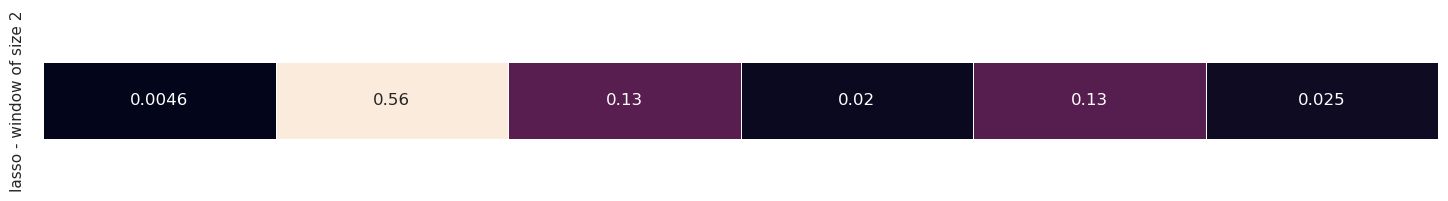

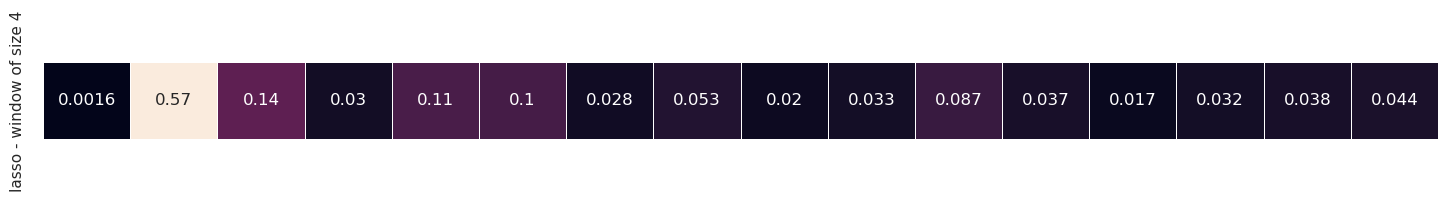

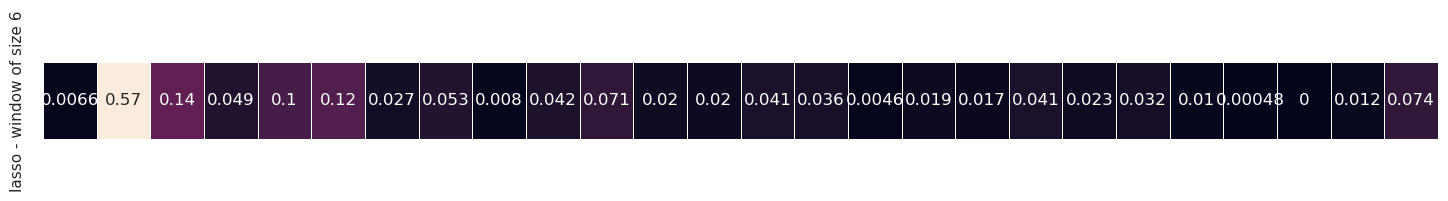

In [34]:
lasso = Lasso(alpha=0.01)
for i, (train, val, test) in divisiones.items():
    X_train = train.drop(columns='wind')
    y_train = train['wind']
    X_val = val.drop(columns='wind')
    y_val = val['wind']

    lasso.fit(X_train, y_train)
    weights = pd.DataFrame({f'lasso - window of size {i}':lasso.coef_},index=X_train.columns)
    weights.T
    fig,  ax = plt.subplots( figsize = (18,1));
    sns.heatmap(weights.T.loc[[f'lasso - window of size {i}'],:].abs(),annot=True, linewidths=.5,ax=ax,cbar=False,xticklabels=False);
    

Para la regresión Lasso, observamos que la correlación de mes con los resultados es casi nula, el factor más importante para determinar 
el viento en un día es el día anterior, seguido a distancia de la lluvia y temperatura máxima el día anterior.
Ciertos parámetros, como la temperatura mínima en el día anterior, tienen una correlación inversa con la posibilidad de lluvia en el día estudiado.

Es interesante observar como, a pesar de que el número de variables aumenta debido a cuantos factores deben ser estudiados con la ampliación de la ventana, las 3 variables más relevantes (viento, lluvia y temperatura máxima en el día anterior) mantienen su mismo peso, mientras que las del resto se dispersan entre las nuevas variables que aparecen al pasar a ventanas mayores.

Continuaremos ahora el análisis generando el q-q plot de la regresión lineal con ventana 6.

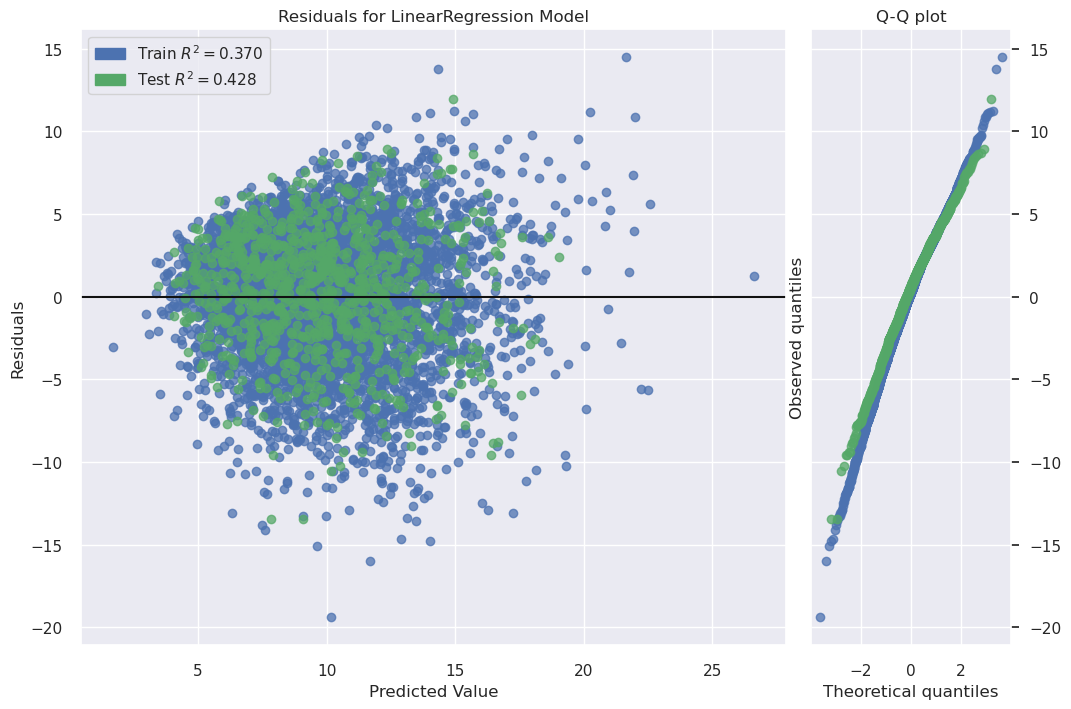

In [35]:
# Columna 0: train / 1: val / 2: test

X_train = divisiones[6][0].drop(columns='wind')
y_train = divisiones[6][0]['wind']

X_val = divisiones[6][1].drop(columns='wind')
y_val = divisiones[6][1]['wind']

plt.figure(figsize=(12,8));
viz = residuals_plot(best_model[1], X_train, y_train, X_val, y_val, is_fitted=True, qqplot=True, hist=False);

Vemos que nuestros residuos, a pesar de parecer que siguen una distribución Gaussiana, son disonantes con los cuantiles teóricos que le hemos pasado.

Por otro lado, el coeficiente de determinación es extremadamente bajo. Este no es un buen modelo de predicción. 

Es posible que esto no se deba a la mala calidad de los datos, pero más debido a que simplemente la separación en el tiempo de los datos dan lugar a conjuntos con características muy separadas, sin correlación entre ellas, y que no permiten predicción en base a los datos de entrenamiento.

## Apartado C

Al predecir el viento nos interesa saber la incertidumbre de la predicción. La regresión
cuantil es un modelo que permite estimar el intervalo de predicción de una regresión. La
regresión se realiza para que las predicciones estén por debajo de un cuantil de probabilidad
determinado. Haciendo la regresión a diferentes cuantiles podemos tener el intervalo de
valores posibles para una predicción. El cuantil 0.5 corresponde a la media de la predicción
de la regresión. Ajusta una regresión cuantil para los cuantiles 0.1, 0.5 y 0.9. Tendrás que
ajustar el peso de la regularización de esta regresión para obtener el mejor modelo usando
la muestra de validación. Selecciona los primeros y últimos 100 instantes de la serie de
test y representa las predicciones de los diferentes cuantiles. Calcula la media y varianza
de la diferencia entre la predicción del cuantil 0.1 y 0.9 para estos dos intervalos para ver
si hay una diferencia. Comenta los resultados.
Representa la predicción del mejor modelo para una pequeña ventana (≈ 100) de datos
de la muestra de test. ¿Crees que la regresión está haciendo una buena aproximación de la serie temporal? ¿Qué características debería 
cumplir esta serie para que la regresión lineal fuera un buen modelo para predecirla?

QuantileRegressor(quantile=0.1)

QuantileRegressor()

QuantileRegressor(quantile=0.9)

<Figure size 1400x700 with 0 Axes>

Text(0.5, 1.0, 'Predicciones de Cuantiles')

Text(0.5, 0, 'Índice')

Text(0, 0.5, 'Velocidad del Viento (m/s)')

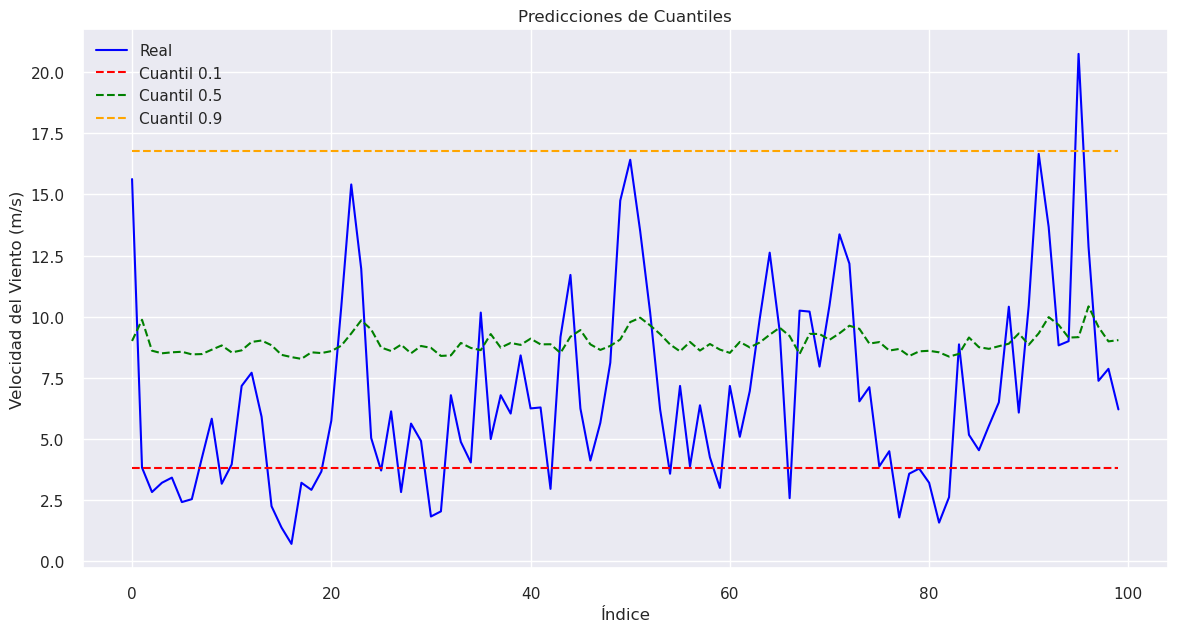

In [36]:
quantiles = [0.1, 0.5, 0.9]
prediccion_cuantiles = {}

# Cogemos los datos de test para compararlos con nuestra predicción
X_test = divisiones[6][2].drop(columns='wind')
y_test = divisiones[6][2]['wind']

for quantil in quantiles:
    quantile_model = QuantileRegressor(quantile=quantil)
    quantile_model.fit(X_train, y_train)
    prediccion_cuantiles[quantil] = quantile_model.predict(X_val)

plt.figure(figsize=(14, 7))
plt.plot(y_val.values[:100], label='Real', color='blue')
plt.plot(prediccion_cuantiles[0.1][:100], label='Cuantil 0.1', color='red', linestyle='--')
plt.plot(prediccion_cuantiles[0.5][:100], label='Cuantil 0.5', color='green', linestyle='--')
plt.plot(prediccion_cuantiles[0.9][:100], label='Cuantil 0.9', color='orange', linestyle='--')
plt.legend()
plt.title('Predicciones de Cuantiles')
plt.xlabel('Índice')
plt.ylabel('Velocidad del Viento (m/s)')
plt.show()

In [37]:
# Obtenemos las predicciones para el conjunto de test
test_prediccion_cuantiles = {}
for q in quantiles:
    model = sm.QuantReg(y_train, sm.add_constant(X_train))
    result = model.fit(q=q)
    test_prediccion_cuantiles[q] = result.predict(sm.add_constant(X_test))

# Calculo de diferencias
diff_first_100 = test_prediccion_cuantiles[0.9][:100] - test_prediccion_cuantiles[0.1][:100]
diff_last_100 = test_prediccion_cuantiles[0.9][-100:] - test_prediccion_cuantiles[0.1][-100:]

# Media y varianza
mean_diff_first = diff_first_100.mean()
var_diff_first = diff_first_100.var()
mean_diff_last = diff_last_100.mean()
var_diff_last = diff_last_100.var()

Media de la diferencia (primeros 100): 8.865854186283876, Varianza: 1.963894038421031
Media de la diferencia (últimos 100): 10.322038707681196, Varianza: 4.449255686167335


<Figure size 1400x700 with 0 Axes>

Text(0.5, 1.0, 'Predicciones del Mejor Modelo')

Text(0.5, 0, 'Índice')

Text(0, 0.5, 'Velocidad del Viento (m/s)')

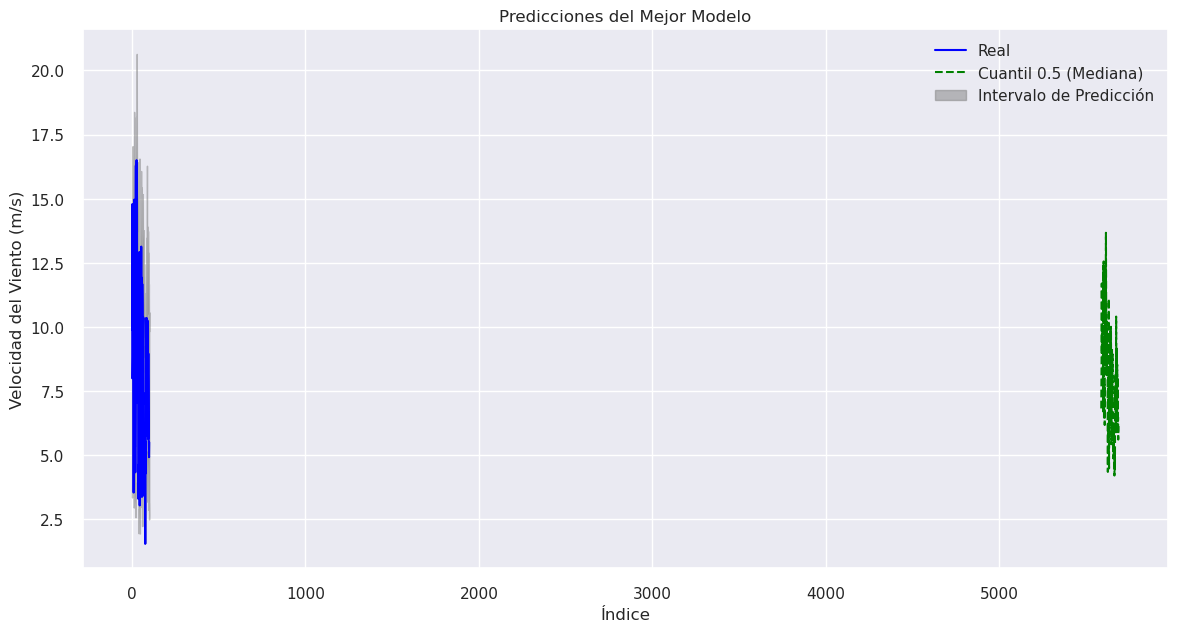

In [38]:
print(f'Media de la diferencia (primeros 100): {mean_diff_first}, Varianza: {var_diff_first}')
print(f'Media de la diferencia (últimos 100): {mean_diff_last}, Varianza: {var_diff_last}')


# Mostramos ahora como se comparan los datos reales con nuestras predicciones
plt.figure(figsize=(14, 7))
plt.plot(y_test.values[:100], label='Real', color='blue')
plt.plot(test_prediccion_cuantiles[0.5][:100], label='Cuantil 0.5 (Mediana)', color='green', linestyle='--')
plt.fill_between(range(100), test_prediccion_cuantiles[0.1][:100], test_prediccion_cuantiles[0.9][:100], color='gray', alpha=0.5, label='Intervalo de Predicción')
plt.legend()
plt.title('Predicciones del Mejor Modelo')
plt.xlabel('Índice')
plt.ylabel('Velocidad del Viento (m/s)')
plt.show()

Observamos en primer lugar que tenemos diferencias de cuantiles bastante elevada, que además crece en los últimos 100 datos. 
Esto nos indica en primer lugar como cambian los datos de entrenamiento con el paso del tiempo, lo cuál ya nos hace a la idea de que 
la predicción mediante estos podría resultar problemática.

La predicción del modelo nos confirma esto, observamos que realiza un trabajo muy pobre para aproximar los valores de test. Asumimos con
estos resultados que nuestro serie NO es lineal, y que por ello nuestro modelo de regresión lineal no puede hacer un buen trabajo. La media
y varianza además no son estacionarias, sino que cambian entre puntos de la predicción, característica indeseable también.

Además de estas características, si hubiésemos querido buenas aproximaciones, habriamos requerido también de que nuestro modelo siguiera una
distribución normal en los residuos.

Observamos en conclusión que para el conjunto de datos de Wind Speed Prediction, sería más razonable un modelo de regresión no lineal.
Los cambios en el tiempo de los datos dificultan ajustar una regresión a esta que aporte buenos resultados.